In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [2]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

In [3]:
entity_name = 'sketchy-opts'
extensions = {
    'adam': 'adam_final',
    'lbfgs': 'lbfgs_final',
    'adam_lbfgs': 'adam_lbfgs_final',
    'adam_lbfgs_10k': 'adam_lbfgs_final_10k',
    'adam_lbfgs_31k': 'adam_lbfgs_final_31k'
}
opt_names = {
    'adam': 'Adam',
    'lbfgs': 'L-BFGS',
    'adam_lbfgs': 'Adam + L-BFGS (1k)',
    'adam_lbfgs_10k': 'Adam + L-BFGS (11k)',
    'adam_lbfgs_31k': 'Adam + L-BFGS (31k)'
}
metric_names = {
    'train/l2re': 'Training L2RE',
    'train/l1re': 'Training L1RE',
    'test/l2re': 'Test L2RE',
    'test/l1re': 'Test L1RE',
    'loss': 'Loss'
}

In [4]:
pde_name = 'reaction_diffusion' # 'wave' # 'convection'
pde_params = ['nu', '6', 'rho', '5'] # ['beta', '5'] # ['beta', '40'] 
metric = 'loss'
opts = ['adam', 'lbfgs', 'adam_lbfgs', 'adam_lbfgs_10k', 'adam_lbfgs_31k']
widths = [50, 100, 200, 400]

In [5]:
def get_best_performance(pde_name, pde_params, metric, opt, widths, entity_name):
    proj_name = f'{pde_name}_{extensions[opt]}'

    # Get the best results for the corresponding metric and pde_params, making sure to separate across widths
    best_results = {}
    for width in widths:
        best_results[width] = np.inf

    api = wandb.Api()
    for run in api.runs(f'{entity_name}/{proj_name}'):
        if run.state != 'finished':
            continue
        config = run.config
        if config['pde_params'] != pde_params:
            continue
        try:
            best_results[config['num_neurons']] = \
                np.minimum(best_results[config['num_neurons']], run.summary[metric]) \
                    if run.summary[metric] is not None else best_results[config['num_neurons']]
        except:
            print(f'Error in {run.name} in {proj_name}, run.summary[metric] = {run.summary[metric]}')

    return best_results

In [6]:
# print(get_best_performance(pde_name, pde_params, metric, 'adam', widths))
# print(get_best_performance(pde_name, pde_params, metric, 'lbfgs', widths))
# print(get_best_performance(pde_name, pde_params, metric, 'adam_lbfgs', widths))
# print(get_best_performance(pde_name, pde_params, metric, 'adam_lbfgs_10k', widths))

In [7]:
def get_best_performance_opts(pde_name, pde_params, metric, opts, widths, entity_name):
    opt_best_results = {}
    for opt in opts:
        opt_best_results[opt] = get_best_performance(pde_name, pde_params, metric, opt, widths, entity_name)
    return opt_best_results

In [8]:
def get_title(pde_name, pde_params):
    if pde_name == "convection":
        return f'Convection, $\\beta = {pde_params[1]}$'
    elif pde_name == "reaction_diffusion":
        return f'Reaction-Diffusion, $\\nu = {pde_params[1]}, \\rho = {pde_params[3]}$'
    elif pde_name == "wave":
        return f'Wave, $\\beta = {pde_params[1]}$'

In [9]:
opt_best_results = get_best_performance_opts(pde_name, pde_params, metric, opts, widths, entity_name)
# for opt in opts:
#     print(opt_best_results[opt])

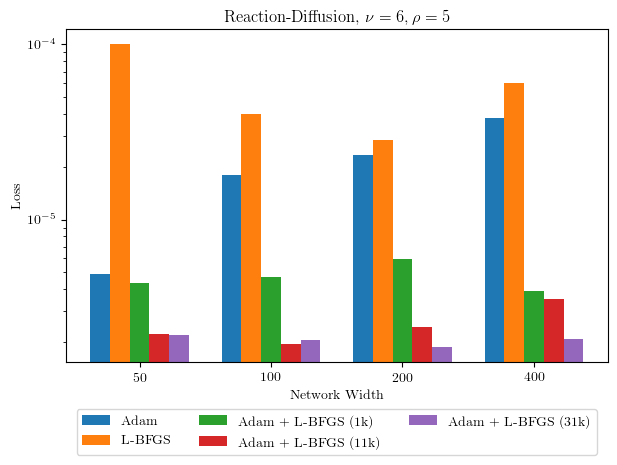

In [10]:
# Make a single bar plot of the best results, comparing across optimizers and widths
width = 0.15
fig, ax = plt.subplots()
for i, opt in enumerate(opts):
    ax.bar(np.arange(len(widths)) + i * width, [opt_best_results[opt][width] for width in widths], width, label=opt_names[opt])
ax.set_yscale('log')
ax.set_ylabel(metric_names[metric])
ax.set_xlabel('Network Width')
ax.set_xticks(np.arange(len(widths)) + (len(opts) - 1) * width / 2)
ax.set_xticklabels(widths)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncols=3)
ax.set_title(get_title(pde_name, pde_params))
fig.tight_layout()
plt.show()

In [13]:
# def plot_best_performance_multi_pde(pdes, metrics, opts, widths, entity_name, opt_names, metric_names, font_size=10):
#     # Set the global font size
#     mpl.rcParams.update({'font.size': font_size})

#     nrows = len(metrics)
#     ncols = len(pdes)

#     fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))  # Adjust figsize as needed

#     for row, metric in enumerate(metrics):
#         for col, (pde_name, pde_params) in enumerate(pdes):
#             opt_best_results = get_best_performance_opts(pde_name, pde_params, metric, opts, widths, entity_name)
#             width = 0.15

#             ax = axs[row, col] if nrows > 1 and ncols > 1 else (axs[col] if nrows == 1 else axs[row])
#             for i, opt in enumerate(opts):
#                 ax.bar(np.arange(len(widths)) + i * width, [opt_best_results[opt][width] for width in widths], width, label=opt_names[opt])

#             ax.set_yscale('log')
#             ax.set_ylabel(metric_names[metric])
#             ax.set_xlabel('Network Width')
#             ax.set_xticks(np.arange(len(widths)) + (len(opts) - 1) * width / 2)
#             ax.set_xticklabels(widths)
#             ax.set_title(get_title(pde_name, pde_params))

#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(opts))

#     fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

def plot_best_performance_multi_pde(pdes, metrics, opts, widths, entity_name, opt_names, metric_names, font_size, folder_path, filename):
    mpl.rcParams.update({'font.size': font_size})

    nrows = len(metrics)
    ncols = len(pdes)

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))  # Adjust figsize as needed

    for row, metric in enumerate(metrics):
        for col, (pde_name, pde_params) in enumerate(pdes):
            opt_best_results = get_best_performance_opts(pde_name, pde_params, metric, opts, widths, entity_name)
            width = 0.15

            ax = axs[row, col] if nrows > 1 and ncols > 1 else (axs[col] if nrows == 1 else axs[row])
            for i, opt in enumerate(opts):
                ax.bar(np.arange(len(widths)) + i * width, [opt_best_results[opt][width] for width in widths], width, label=opt_names[opt])

            ax.set_yscale('log')
            ax.set_ylabel(metric_names[metric])
            ax.set_xlabel('Network Width')
            ax.set_xticks(np.arange(len(widths)) + (len(opts) - 1) * width / 2)
            ax.set_xticklabels(widths)
            ax.set_title(get_title(pde_name, pde_params))

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(opts))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Check if the folder exists, and create it if it doesn't
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save the figure in the specified folder
    full_path = os.path.join(folder_path, filename)
    fig.savefig(full_path, bbox_inches='tight')

    plt.show()


Error in misty-music-350 in wave_adam_lbfgs_final, run.summary[metric] = NaN


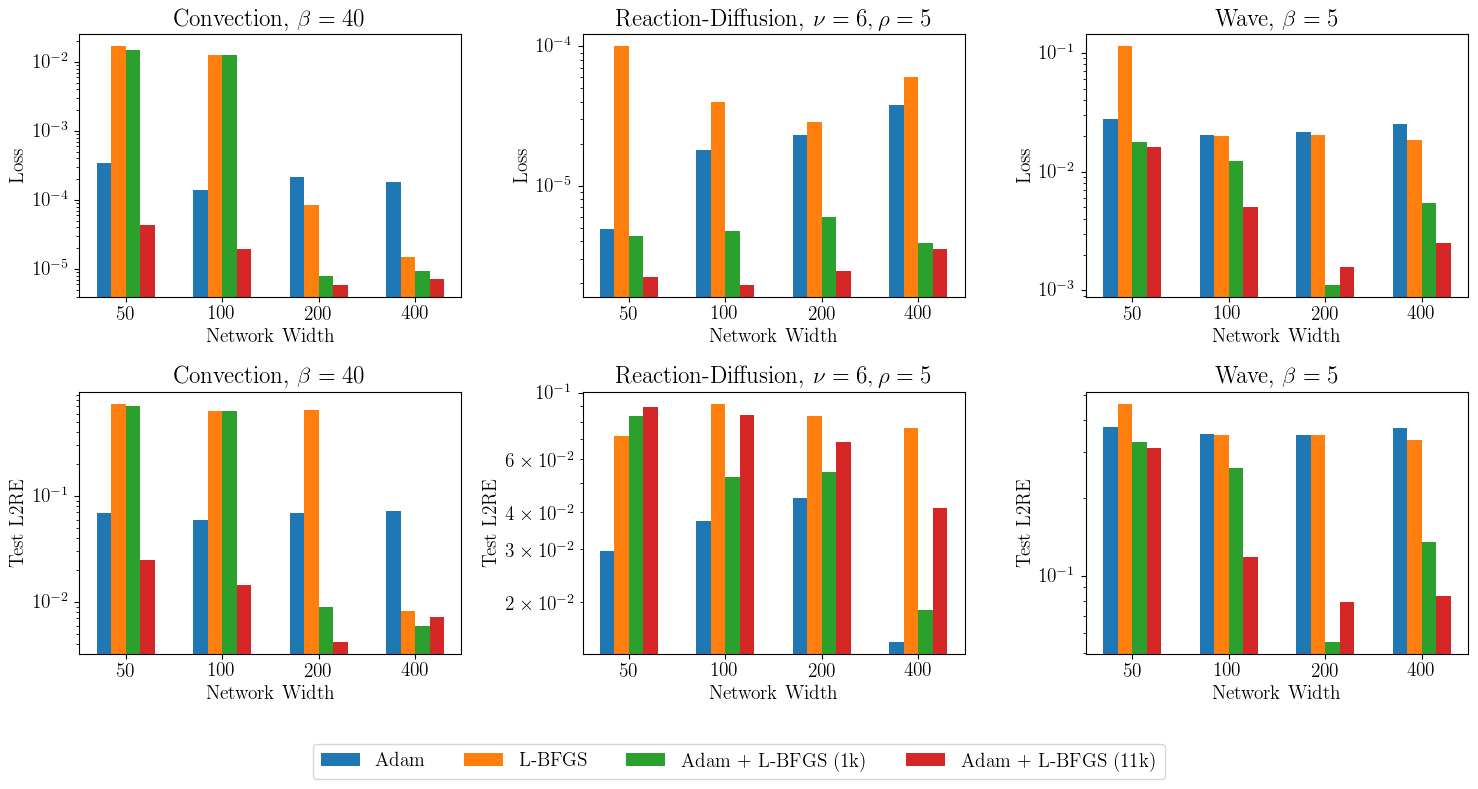

In [14]:
pdes = [('convection', ['beta', '40']), ('reaction_diffusion', ['nu', '6', 'rho', '5']), ('wave', ['beta', '5'])]
metrics = ['loss', 'test/l2re']
opts = ['adam', 'lbfgs', 'adam_lbfgs', 'adam_lbfgs_10k'] #, 'adam_lbfgs_31k']
widths = [50, 100, 200, 400]

plot_best_performance_multi_pde(pdes, metrics, opts, widths, entity_name, opt_names, metric_names, font_size=14, folder_path='opt_comparison_plots', filename='loss_l2re.pdf')